In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import spacy
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
torch.cuda.is_available()

True

In [13]:
# data preprocessing
df = pd.read_csv('text.csv')
df = df.drop_duplicates()

# change the text to one form
df['text'] = df['text'].str.lower().str.replace('[^a-z\s]', '', regex=True)
df = df[['text', 'label']]
print(df.head())
print(df.describe())

# sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5)
cls_list = sorted(df['label'].unique().tolist())
cls_count = df['label'].value_counts()
mapping = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
# print(cls_list)
# print(cls_count)

                                                text  label
0      i just feel really helpless and heavy hearted      4
1  ive enjoyed being able to slouch about relax a...      0
2  i gave up my internship with the dmrg and am f...      4
3                         i dont know i feel so lost      0
4  i am a kindergarten teacher and i am thoroughl...      4
               label
count  416809.000000
mean        1.554271
std         1.490453
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max         5.000000


In [15]:
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    # obtain a list of separated words from the sentence
    text_split = text.split()
    # construct a new list with stop words removed
    words_nostop = [w for w in text_split if w not in stop_words]

    return " ".join(words_nostop)

# remove the stop words in df
df["text"] = df["text"].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\benro\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [16]:
tokenizer = get_tokenizer('basic_english')

# tokenize text in the df and build vocabulary
def yield_tokens(df):
    for text in df['text']:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(df))

text = [[vocab[token] for token in tokenizer(sentence)] for sentence in df['text']]
sequences = pad_sequence([torch.tensor(seq) for seq in text], batch_first=True, padding_value=vocab["<unk>"])

# split the data into train and test set
x_train, x_test, y_train, y_test = train_test_split(sequences, df['label'], train_size=0.8, shuffle=True, stratify=df['label'])
# change the type of labels in the dataset to tensor
y_train_tensor = torch.tensor(y_train.values if isinstance(y_train, pd.Series) else y_train)
y_test_tensor = torch.tensor(y_test.values if isinstance(y_test, pd.Series) else y_test)

# create TensorDataset for both training and testing sets
train_dataset = TensorDataset(x_train, y_train_tensor)
test_dataset = TensorDataset(x_test, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

416809lines [00:02, 194526.26lines/s]


In [17]:
print(train_dataset[9990])

(tensor([   4, 7829, 1405, 1473,    2,  607,  546, 4256,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0]), tensor(0))


In [ ]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout1 = nn.Dropout(0.1)
        self.conv1d = nn.Conv1d(embedding_dim, 128, kernel_size=3, padding=1)  # added padding for size compatibility
        self.maxpool1d = nn.MaxPool1d(kernel_size=3)
        self.lstm = nn.LSTM(128, 64, batch_first=True, bidirectional=True)
        self.dropout2 = nn.Dropout(0.1)
        self.fc1 = nn.Linear(64*2, 512)  # 64*2 for bidirectional
        self.dropout3 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout1(x)
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1d(x))
        x = self.maxpool1d(x)
        x, _ = self.lstm(x.permute(0, 2, 1))
        x = self.dropout2(x[:, -1, :])
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [19]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, device):
    model = model.to(device)

    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []

    epochs = 30
    for epoch in range(epochs):
        model.train()
        train_correct, train_total, train_loss = 0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # zero the parameter gradients
            outputs = model.forward(inputs)  # forward pass
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            train_loss += loss.item()

        train_accuracy = 100 * train_correct / train_total
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss / len(train_loader))

        # validation
        model.eval()  # set model to evaluate mode
        val_correct, val_total, val_loss = 0, 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_loss += loss.item()

        val_accuracy = 100 * val_correct / val_total
        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss / len(val_loader))

        print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Train Accuracy: {train_accuracies[-1]:.2f}% | Val Loss: {val_losses[-1]:.4f} | Val Accuracy: {val_accuracies[-1]:.2f}%')

    # plotting
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


Epoch 1/30 | Train Loss: 0.7031 | Train Accuracy: 72.92% | Val Loss: 0.1611 | Val Accuracy: 92.61%
Epoch 2/30 | Train Loss: 0.1492 | Train Accuracy: 92.74% | Val Loss: 0.1282 | Val Accuracy: 93.22%
Epoch 3/30 | Train Loss: 0.1232 | Train Accuracy: 93.28% | Val Loss: 0.1119 | Val Accuracy: 93.29%
Epoch 4/30 | Train Loss: 0.1144 | Train Accuracy: 93.53% | Val Loss: 0.1122 | Val Accuracy: 93.57%
Epoch 5/30 | Train Loss: 0.1101 | Train Accuracy: 93.63% | Val Loss: 0.1040 | Val Accuracy: 93.60%
Epoch 6/30 | Train Loss: 0.1055 | Train Accuracy: 93.73% | Val Loss: 0.1055 | Val Accuracy: 93.71%
Epoch 7/30 | Train Loss: 0.1044 | Train Accuracy: 93.78% | Val Loss: 0.1084 | Val Accuracy: 93.63%
Epoch 8/30 | Train Loss: 0.1032 | Train Accuracy: 93.87% | Val Loss: 0.1126 | Val Accuracy: 93.64%
Epoch 9/30 | Train Loss: 0.1020 | Train Accuracy: 93.90% | Val Loss: 0.1099 | Val Accuracy: 93.66%
Epoch 10/30 | Train Loss: 0.1007 | Train Accuracy: 93.99% | Val Loss: 0.1104 | Val Accuracy: 93.69%
Epoch 11/

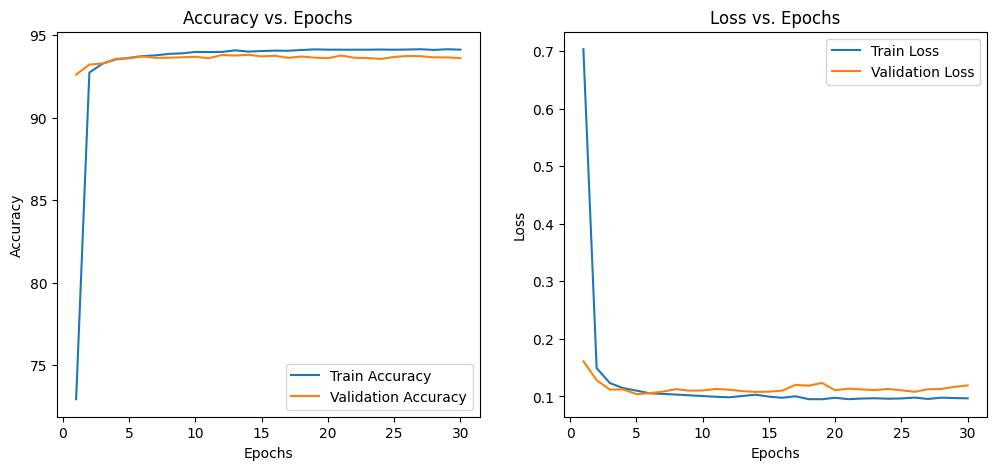

In [20]:
model = LSTM(len(vocab), 100, 6)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.RMSprop(model.parameters(), lr=0.002)
train_and_validate(model, train_loader, test_loader, criterion, optimizer, device='cuda')

In [27]:
from sklearn.metrics import classification_report

def test_model(model, test_loader, device):
    model.eval()  # set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # no need to track the gradients
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # calculate and print the classification report
    print(classification_report(all_labels, all_preds, target_names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']))

test_model(model, test_loader, 'cuda')

              precision    recall  f1-score   support

     sadness       0.95      0.99      0.97     24238
         joy       0.99      0.91      0.95     28214
        love       0.78      0.99      0.87      6911
       anger       0.96      0.91      0.94     11463
        fear       0.94      0.85      0.89      9542
    surprise       0.73      0.97      0.84      2994

    accuracy                           0.94     83362
   macro avg       0.89      0.94      0.91     83362
weighted avg       0.94      0.94      0.94     83362

